# Imports

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import scqubits as scq
from scipy.linalg import expm

# Part 1

You could try to setup an example where you do an X gate on a fluxonium qubit; that would involve using scqubits to get the hamiltonian...  write down the drive term (which would be just a linear ~A*cos(omega_d*t)*phi, here phi is the phase degree of freedom), and see if you can drive an X gate that causes a transition 0->1 

In [90]:
print(scq.__version__)

scq.set_units("GHz")

4.3.1


 c:\Users\Owner\anaconda3\Lib\site-packages\scqubits\core\units.py: 65

'GHz'

In [91]:
fluxonium = scq.Fluxonium(
    EJ=8.9,
    EC=2.5,
    EL=0.5,
    cutoff = 110,
    flux = 0.5
)

In [92]:
fluxonium.eigenvals()

array([-0.63001146, -0.26659009,  8.75633751, 11.69881054, 16.67252211,
       17.42908833])

## Break it apart

In [93]:
print("Making the fluxonium qubit")

EJ = 2.55  
EC = 0.72  
EL = 0.12  
flux = 0.0 # External flux quantum
cutoff = 30 # Hilbert space cutoff
    
fluxonium = scq.Fluxonium(
    EJ=EJ,
    EC=EC, 
    EL=EL,
    flux=flux,
    cutoff=cutoff
)

fluxonium

Making the fluxonium qubit


Fluxonium(**{'EJ': 2.55, 'EC': 0.72, 'EL': 0.12, 'flux': 0.0, 'cutoff': 30, 'truncated_dim': 6, 'id_str': 'Fluxonium_13', 'evals_method': None, 'evals_method_options': None, 'esys_method': None, 'esys_method_options': None})

In [94]:
print("Calculating drive parameters")

evals, evecs = fluxonium.eigensys(evals_count=3)
    
# Transition frequency between 0 and 1 states
omega_01 = evals[1] - evals[0] 
    
phi_op = fluxonium.phi_operator()
    
phi_01 = np.abs(evecs[:, 0].conj().T @ phi_op @ evecs[:, 1])
    
print(f"Transition frequency omega_01 = {omega_01:.3f} GHz")
print(f"Phase matrix element <0|phi|1> = {phi_01:.3f}")

Calculating drive parameters
Transition frequency omega_01 = 2.159 GHz
Phase matrix element <0|phi|1> = 0.356


In [95]:
print("Simulating X gate")

drive_amplitude = 0.05  # Adjust this for different Rabi frequencies

# For a π-pulse: Ω * t = π, where Ω = A * φ_01
rabi_freq = drive_amplitude * phi_01  # Effective Rabi frequency
gate_time = np.pi / (2*np.pi * rabi_freq)

print(f"Drive amplitude A = {drive_amplitude:.3f} GHz")
print(f"Rabi frequency Ω = {drive_amplitude * phi_01:.3f} GHz") 
print(f"Gate time = {gate_time:.3f} ns")

# Time array
dt = 0.01  # time step in ns
times = np.arange(0, gate_time + dt, dt)

H0 = np.diag([evals[0], evals[1]])  # Static Hamiltonian

# Drive Hamiltonian H_drive = A * cos(ω_d * t) * φ
# In 2-level approximation: σ_x matrix elements
sigma_x = np.array([[0, 1], [1, 0]])

# Initialize state 0
psi0 = np.array([1.0, 0.0], dtype=complex)

# Store results
populations = np.zeros((len(times), 2))
populations[0] = [1.0, 0.0]  # Initial state

psi = psi0.copy()

for i, t in enumerate(times[1:], 1):
    # Drive Hamiltonian in rotating frame
    H_total = 0.5 * drive_amplitude * phi_01 * sigma_x
        
    U = expm(-1j * H_total * dt * 2 * np.pi)  # Factor of 2pi
    
    psi = U @ psi
    
    populations[i] = [np.abs(psi[0])**2, np.abs(psi[1])**2]

Simulating X gate
Drive amplitude A = 0.050 GHz
Rabi frequency Ω = 0.018 GHz
Gate time = 28.107 ns


Plotting results


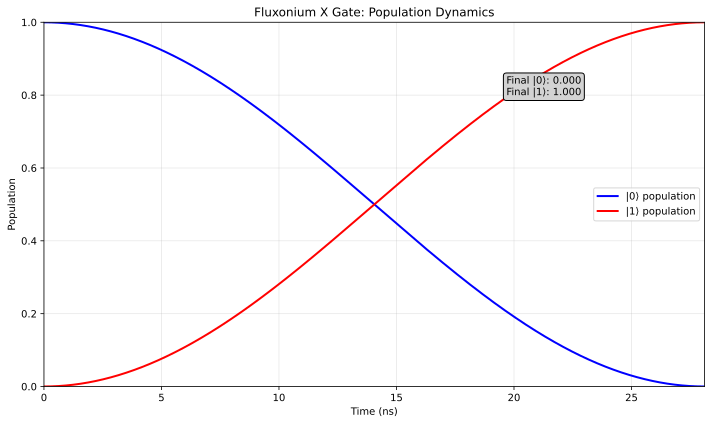

In [96]:
print("Plotting results")

plt.figure(figsize=(10, 6))
plt.plot(times, populations[:, 0], 'b-', linewidth=2, label='|0⟩ population')
plt.plot(times, populations[:, 1], 'r-', linewidth=2, label='|1⟩ population') 
plt.xlabel('Time (ns)')
plt.ylabel('Population')
plt.title('Fluxonium X Gate: Population Dynamics')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, times[-1])
plt.ylim(0, 1)

# Annotation for final populations
final_p0 = populations[-1, 0]
final_p1 = populations[-1, 1]
plt.text(0.7 * times[-1], 0.8, f'Final |0⟩: {final_p0:.3f}\nFinal |1⟩: {final_p1:.3f}', 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))

plt.tight_layout()
plt.show()

In [97]:
print("Results")

print(f"X gate fidelity: {final_p1:.3f}")
print(f"Leakage to |0⟩: {final_p0:.3f}")

if final_p1 > 0.95:
    print("Population successfully transferred from |0⟩ to |1⟩")
else:
    print("X gate needs optimization. Try adjusting drive amplitude or gate time.")

Results
X gate fidelity: 1.000
Leakage to |0⟩: 0.000
Population successfully transferred from |0⟩ to |1⟩


# Part 2

Another thing to try would be to try to reproduce (even partially) some of the results from that wilhelm paper where they embed two qubits into a single transmon... there could just use qutip and qutip-ctrl to find the right pulses. 

In [98]:
from qutip import *
from qutip_qtrl import *

In [99]:
#equation 1

def hamiltonian(Ec, Ej, N, ng):
    """
    Return the charge qubit hamiltonian as a Qobj instance.
    """
    m = np.diag(4 * Ec * (np.arange(-N, N + 1) - ng) ** 2) + 0.5 * Ej * (
        np.diag(-np.ones(2 * N), 1) + np.diag(-np.ones(2 * N), -1)
    )
    return Qobj(m)

hamiltonian(1.0, 1.0, 10, 0.5)
     

Quantum object: dims=[[21], [21]], shape=(21, 21), type='oper', dtype=Dense, isherm=True
Qobj data =
[[441.   -0.5   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ -0.5 361.   -0.5   0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  0.   -0.5 289.   -0.5   0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  0.    0.   -0.5 225.   -0.5   0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  0.    0.    0.   -0.5 169.   -0.5   0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  0.    0.    0.    0.   -0.5 121.   -0.5   0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  0.    0.    0.    0.    0.   -0.5  81.   -0.5   0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    

In [100]:
# from the lecture 11 for charge qubits

def plot_energies(ng_vec, energies, ymax=(20, 3)):
    """
    Plot energy levels as a function of bias parameter ng_vec.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    for n in range(len(energies[0, :])):
        axes[0].plot(ng_vec, energies[:, n])
    axes[0].set_ylim(-2, ymax[0])
    axes[0].set_xlabel(r"$n_g$", fontsize=18)
    axes[0].set_ylabel(r"$E_n$", fontsize=18)

    for n in range(len(energies[0, :])):
        axes[1].plot(
            ng_vec,
            (energies[:, n] - energies[:, 0]) /
            (energies[:, 1] - energies[:, 0]),
        )
    axes[1].set_ylim(-0.1, ymax[1])
    axes[1].set_xlabel(r"$n_g$", fontsize=18)
    axes[1].set_ylabel(r"$(E_n-E_0)/(E_1-E_0)$", fontsize=18)
    return fig, axes

def visualize_dynamics(result, ylabel):
    """
    Plot the evolution of the expectation values stored in result.
    """
    fig, ax = plt.subplots(figsize=(12, 5))

    ax.plot(result.times, result.expect[0])

    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel(r"$t$", fontsize=16);

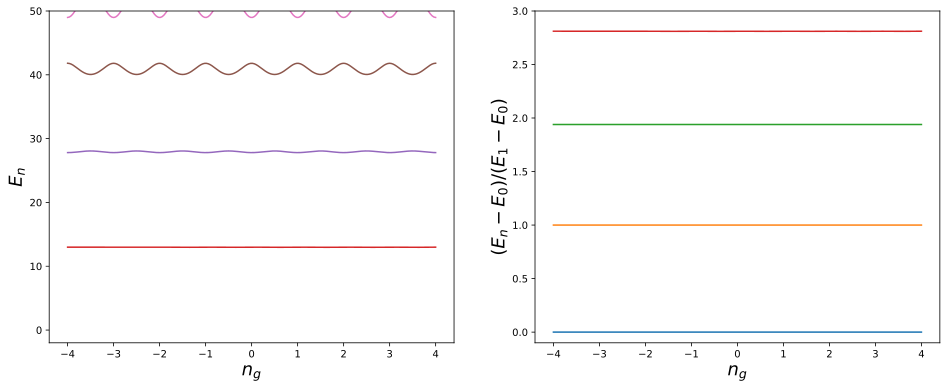

In [102]:
#define a transmon

Ec = 1.0
Ej = 50.0
N = 10
ng_vec = np.linspace(-4, 4, 200)

energies = np.array([hamiltonian(Ec, Ej, N, ng).eigenenergies()
                     for ng in ng_vec])

plot_energies(ng_vec, energies, ymax=(50, 3));


In [ ]:
#equation 2

N = 10             # Hilbert space dimension
omega = 1.0        # Harmonic oscillator frequency
lam = -0.05        # Anharmonicity (λ), negative for transmons

# Operators
a = destroy(N)               # Annihilation operator
adag = a.dag()               # Creation operator
n = adag * a                 # Number operator

# Hamiltonian
H_an = omega * n + (lam / 2) * adag * adag * a * a

H_an

Quantum object: dims=[[10], [10]], shape=(10, 10), type='oper', dtype=Dia, isherm=True
Qobj data =
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.95 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   2.85 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   3.7  0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   4.5  0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   5.25 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   5.95 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   6.6  0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   7.2 ]]